In [1]:
!pip install fasttext natasha
!pip install csv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 38.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 74.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=bc405eb489ec17b8b58325b3d664788e6419affd57c2d58765eb5b2a4991f192
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [2]:
import re
import csv
import string
import random
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from scipy.stats import ks_2samp
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger
import fasttext
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)


months = [
    "январь", "февраль", "март", "апрель", "май", "июнь",
    "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"
]

# Стоп-слова
russian_stopwords = set(stopwords.words("russian"))
russian_stopwords.discard('за')  
russian_stopwords.update(['кг', 'сумма', 'тч', 'мл', 'счёт'])  


def clear(text, russian_stopwords, segmenter, morph_vocab, morph_tagger, months):
    date_pattern = r"(\d{0,4}[./-]?)"
    cleaned_text = re.sub(date_pattern, "", text)
    
    tokens = word_tokenize(cleaned_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords]
    tokens = [token for token in tokens if token not in string.punctuation]
    cleaned_text = ' '.join(tokens)
    
    doc = Doc(cleaned_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    lemmas = [token.lemma for token in doc.tokens if token.lemma not in months and len(token.lemma) > 1]
    
    return ' '.join(lemmas)

In [4]:
input_file_train = "/kaggle/input/for-dataset/train.csv" 
output_train = "train.txt" 

with open(input_file_train, "r", encoding="utf-8") as csvfile, open(output_train, "w", encoding="utf-8") as outfile:
    reader = csv.reader(csvfile, delimiter=",")  
    next(reader)  
    for row in reader:
        try:
            label = row[2]  
            text = clear(row[1],russian_stopwords, segmenter, morph_vocab, morph_tagger, months) 
            outfile.write(f"__label__{label} {text}\n")
        except IndexError:
            print(f"Пропущена строка из-за недостатка столбцов: {row}")


input_file_test = '/kaggle/input/for-dataset/test.csv'
output_test = "test.txt" 

with open(input_file_test, "r", encoding="utf-8") as csvfile, open(output_test, "w", encoding="utf-8") as outfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)  
    for row in reader:
        try:
            label = row[2]  
            text = clear(row[1],russian_stopwords, segmenter, morph_vocab, morph_tagger, months) 
            outfile.write(f"__label__{label} {text}\n")
        except IndexError:
            print(f"Пропущена строка из-за недостатка столбцов: {row}")


In [5]:
#Обучаем модель 
model = fasttext.train_supervised(input="train.txt", epoch=1000, lr=0.1, wordNgrams=3)

Read 0M words
Number of words:  537
Number of labels: 9
Progress: 100.0% words/sec/thread:  497053 lr:  0.000000 avg.loss:  0.027324 ETA:   0h 0m 0s


In [6]:
result = model.test("test.txt")
print(f"Точность: {result[1]}")

Точность: 0.97


In [7]:
true_labels = []  
texts = [] 
prob_all = []
with open("test.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.split()
        label = parts[0].replace("__label__", "")  
        text = " ".join(parts[1:])  
        true_labels.append(label)
        texts.append(text)


predicted_labels = []
for text in texts:
    label, prob = model.predict(text,k=-1)
    predicted_labels.append(label[0].replace("__label__", ""))
    prob_all.append(prob)

In [8]:
print(classification_report(true_labels, predicted_labels))

f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f"Weighted F1-score: {f1:.2f}")

                precision    recall  f1-score   support

  BANK_SERVICE       1.00      1.00      1.00        10
    FOOD_GOODS       1.00      0.83      0.91        18
       LEASING       1.00      1.00      1.00         7
          LOAN       1.00      1.00      1.00         8
NON_FOOD_GOODS       0.86      1.00      0.93        19
NOT_CLASSIFIED       1.00      1.00      1.00         5
   REALE_STATE       1.00      1.00      1.00         5
       SERVICE       1.00      1.00      1.00        18
           TAX       1.00      1.00      1.00        10

      accuracy                           0.97       100
     macro avg       0.98      0.98      0.98       100
  weighted avg       0.97      0.97      0.97       100

Weighted F1-score: 0.97


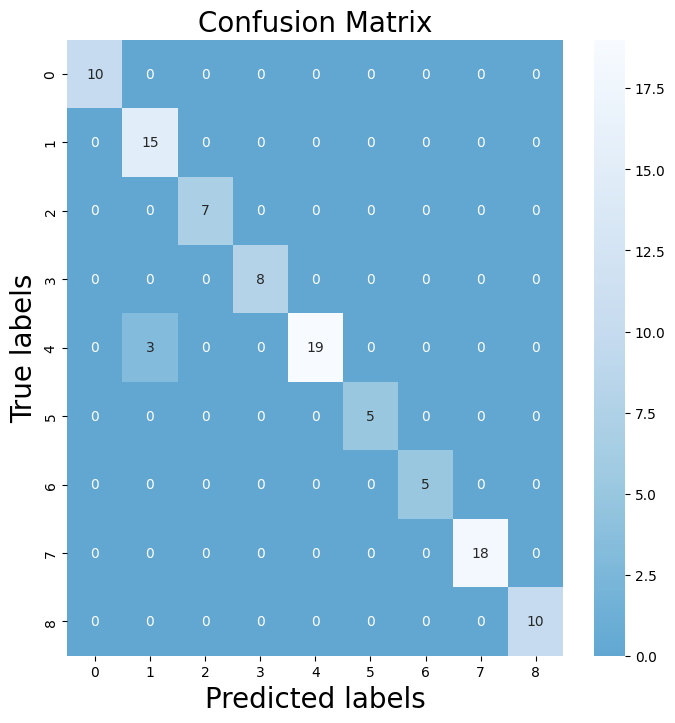

In [9]:
CM = confusion_matrix(predicted_labels,true_labels)
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(CM, center = True, fmt='g',ax=ax,annot=True,cmap='Blues_r')
ax.set_xlabel('Predicted labels',fontsize=20)
ax.set_ylabel('True labels',fontsize=20) 
ax.set_title('Confusion Matrix',fontsize=20)
plt.show()

In [10]:
def calculate_gini_multiclass(true_labels, predicted_probabilities, classes):
    num_classes = len(classes)
    gini_per_class = []
    
    for class_idx, class_name in enumerate(classes):
        binary_true_labels = np.array([1 if label == class_name else 0 for label in true_labels])
        
        roc_auc = roc_auc_score(binary_true_labels, predicted_probabilities[:, class_idx])
        
        gini = 2 * roc_auc - 1
        gini_per_class.append(gini)
    
    mean_gini = np.mean(gini_per_class)
    return mean_gini, dict(zip(classes, gini_per_class))


true_labels = []
texts = []

with open("test.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.split()
        label = parts[0].replace("__label__", "")  
        text = " ".join(parts[1:])
        true_labels.append(label)
        texts.append(text)


classes = list(set(true_labels))


num_classes = len(classes)
predicted_probabilities = np.zeros((len(texts), num_classes))

for idx, text in enumerate(texts):
    labels, probabilities = model.predict(text, k=num_classes)  
    for label, prob in zip(labels, probabilities):
        class_idx = classes.index(label.replace("__label__", "")) 
        predicted_probabilities[idx, class_idx] = prob

mean_gini, gini_per_class = calculate_gini_multiclass(true_labels, predicted_probabilities, classes)

print(f"Средний Gini Coefficient: {mean_gini:.4f}")
for class_name, gini in gini_per_class.items():
    print(f"Класс {class_name}: Gini = {gini:.4f}")


Средний Gini Coefficient: 0.9971
Класс LEASING: Gini = 1.0000
Класс REALE_STATE: Gini = 1.0000
Класс NOT_CLASSIFIED: Gini = 1.0000
Класс NON_FOOD_GOODS: Gini = 0.9870
Класс BANK_SERVICE: Gini = 1.0000
Класс LOAN: Gini = 1.0000
Класс SERVICE: Gini = 1.0000
Класс TAX: Gini = 1.0000
Класс FOOD_GOODS: Gini = 0.9864


In [11]:
#Определяем функцию
def calculate_ks_multiclass(true_labels, predicted_probabilities, classes):
    ks_stats = {}
    for class_idx, class_name in enumerate(classes):
        class_probs = predicted_probabilities[:, class_idx]
        
        binary_labels = np.array([1 if label == class_name else 0 for label in true_labels])
        
        probs_class = class_probs[binary_labels == 1]
        probs_other = class_probs[binary_labels == 0]
        
        ks_stat, p_value = ks_2samp(probs_class, probs_other)
        ks_stats[class_name] = {"KS Statistic": ks_stat, "p-value": p_value}
    
    return ks_stats

true_labels = []
texts = []


#Тут читаем данные 
with open("test.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.split()
        label = parts[0].replace("__label__", "")  
        text = " ".join(parts[1:])
        true_labels.append(label)
        texts.append(text)


classes = list(set(true_labels))


num_classes = len(classes)
predicted_probabilities = np.zeros((len(texts), num_classes))

#Тут преобразовываем данные 
for idx, text in enumerate(texts):
    labels, probabilities = model.predict(text, k=num_classes)  
    for label, prob in zip(labels, probabilities):
        class_idx = classes.index(label.replace("__label__", ""))  
        predicted_probabilities[idx, class_idx] = prob


ks_stats = calculate_ks_multiclass(true_labels, predicted_probabilities, classes)


#Тут выводим статистики 
for class_name, stats in ks_stats.items():
    print(f"Класс: {class_name}")
    print(f"  KS Statistic: {stats['KS Statistic']:.4f}")
    print(f"  p-value: {stats['p-value']:.4f}")



Класс: LEASING
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: REALE_STATE
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: NOT_CLASSIFIED
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: NON_FOOD_GOODS
  KS Statistic: 0.9630
  p-value: 0.0000
Класс: BANK_SERVICE
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: LOAN
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: SERVICE
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: TAX
  KS Statistic: 1.0000
  p-value: 0.0000
Класс: FOOD_GOODS
  KS Statistic: 0.9512
  p-value: 0.0000


In [12]:
mean_kolmogor = []
p_value = []
for label,stats in list(ks_stats.items()):
    mean_kolmogor.append(stats['KS Statistic'])
    p_value.append(stats['p-value'])
print(f'Средняя статистика Колмогорова-Смирнова:{np.mean(mean_kolmogor)}, максимальное p-value: {max(p_value)}')

Средняя статистика Колмогорова-Смирнова:0.9904647194620095, максимальное p-value: 2.656482774303099e-08
